In [52]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
print(torch.__version__) # The Plateau scheduler.get_last_lr only works with version after 2.1.0 for some reason
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

2.2.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [47]:
''' Predictor with eight inputs and one outputs. For now only for the momentum fluxes. 
    [Wind, Ua-Uo, W1_cos, W1_lp, W1_hs, W2_cos, W2_lp, W2_hs].
'''
class Flux82(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0,0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,1,1,100,10,1,100,10]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,0.1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}

''' Basically RealFluxDataset but with random permutation added '''   
class WaveFluxDatasetPerm (RealFluxDataset):
    def __getitem__(self, idx):
        # With 50% chance permutate the two wave systems
        if np.random.rand() > 0.5:
            self.Xperm = torch.cat([self.X[idx][:-6], self.X[idx][-3:], self.X[idx][-6:-3]])
            return self.Xperm, self.Y[idx], self.W[idx]
        else:
            return self.X[idx], self.Y[idx], self.W[idx]

In [5]:
###### We perform some transformation of the variables ######
def quantities(ds):
    ds['t_diff'] = ds.tair - ds.tsea
    ds['pcos0'] = np.cos(np.deg2rad(ds.wdir-ds.pdir0))
    ds['pcos1'] = np.cos(np.deg2rad(ds.wdir-ds.pdir1))
    
quantities(psd)

In [35]:
###### Network hyperparameter ######
para1 = {'n_in':8,'n_out':2,'hidden_channels':[32,16,16]}
para2 = {'n_in':8,'n_out':2,'hidden_channels':[32,16,16]}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','t_diff','pcos0','plp0','phs0','pcos1','plp1','phs1']
    okeys = ['taucx','taucy']
    bkeys = ['taubx','tauby']
    training_data = WaveFluxDatasetPerm(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = WaveFluxDatasetPerm(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = WaveFluxDatasetPerm(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    
    ###### Later run a set that has only non-wave 
    for run in range(2):   
        model = Flux82({'mean_ann_para':para1, 'var_ann_para':para2})
        model.datasplit = split
        training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2}
        log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
        # Later we can pick one before saving but since files are pretty small they are ok 
        model.save(fname="../../saved_model/permutated_waves_split%g_run%g" %(i+1,run))
        

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
training took 135.18 seconds, loss at last epoch -132.7914
training took 134.16 seconds, loss at last epoch -134.5650
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
training took 166.14 seconds, loss at last epoch -142.6320
training took 164.04 seconds, loss at last epoch -143.6957
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
training took 141.40 seconds, loss at last epoch -153.1060
training took 141.36 seconds, loss at last epoch -151.8945
Training samples: 9194
Validating samples: 879
Testing samples: 879
training took 174.51 seconds, loss at last epoch -149.6415
training took 173.54 seconds, loss at last epoch -150.3693
Training samples: 8826
Validating samples: 1247
Testing samples: 1247
training took 169.15 seconds, loss at last epoch -131.2130
training took 166.71 seconds, loss at last epoch -130.6100
Training samples: 9453
Validating samples: 620
Testing samples

In [ ]:
####### Try implementing exahnge of wave system 1 and 2 and feeding it twice

####### We need to ensure complete symmetry between the two wave systems
####### Or we could just use mean waves

####### Try implementing early stopping

In [36]:
###### Evaluate ######
ikeys = ['U','t_diff','pcos0','plp0','phs0','pcos1','plp1','phs1']
okeys = ['taucx','taucy']
bkeys = ['taubx','tauby']
    
import pickle
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

# from mlflux.utils import mse_r2
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

for i in range(6):
    for run in (0,1):
        # with open('../../saved_model/full_anns_waves_split%g_run%g.p' %(i+1,run), 'rb') as pickle_file:
        with open('../../saved_model/permutated_waves_split%g_run%g.p' %(i+1,run), 'rb') as pickle_file:    
            model = pickle.load(pickle_file)
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=model.datasplit, PLOT=False, XVIS='samples')
        ###### Initiate the Dataset class and use default weighting ######
        training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
        validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
        testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)       
        model.metrics(validating_data.X, validating_data.Y)
        bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
        model.bulk_scores = {'mse':bulk_mse, 'r2':bulk_r2}
        print('NN r2' + str(model.scores['r2'].numpy()))
    print('Bulk r2' + str(model.bulk_scores['r2']))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
NN r2[ 0.85094064 -0.1435237 ]
Training samples: 7005
Validating samples: 3068
Testing samples: 3068
NN r2[ 0.85071445 -0.10178483]
Bulk r2[ 0.87180203 -0.00589943]
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
NN r2[ 0.40829504 -0.01983929]
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
NN r2[ 0.40510923 -0.02072418]
Bulk r2[ 0.37037188 -0.00241661]
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
NN r2[ 0.51570755 -0.00400865]
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
NN r2[ 0.5126934 -0.0054096]
Bulk r2[ 0.4882151  -0.08457267]
Training samples: 9194
Validating samples: 879
Testing samples: 879
NN r2[ 0.86365163 -0.01657426]
Training samples: 9194
Validating samples: 879
Testing samples: 879
NN r2[ 0.8662101  -0.04127681]
Bulk r2[ 0.8757325  -0.03921318]
Training samples: 8826
Validating samples: 1247
Testing samples: 1

### Try early stopping

In [66]:
''' Predictor with eight inputs and one outputs. For now only for the momentum fluxes. 
    [Wind, Ua-Uo, W1_cos, W1_lp, W1_hs, W2_cos, W2_lp, W2_hs].
'''
class Flux81(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0,0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,1,1,100,10,1,100,10]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}

''' Basically RealFluxDataset but with random permutation added '''   
class WaveFluxDatasetPerm (RealFluxDataset):
    def __getitem__(self, idx):
        # With 50% chance permutate the two wave systems
        if np.random.rand() > 0.5:
            self.Xperm = torch.cat([self.X[idx][:-6], self.X[idx][-3:], self.X[idx][-6:-3]])
            return self.Xperm, self.Y[idx], self.W[idx]
        else:
            return self.X[idx], self.Y[idx], self.W[idx]

In [70]:
para1 = {'n_in':8,'n_out':1,'hidden_channels':[32,16,16],'ACTIVATION':'no'}
para2 = {'n_in':8,'n_out':1,'hidden_channels':[32,16,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

split = split_ensem[1]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

###### Initiate the Dataset class and use default weighting ######
ikeys = ['U','t_diff','pcos0','plp0','phs0','pcos1','plp1','phs1']
okeys = ['taucx']
bkeys = ['taubx']
training_data = WaveFluxDatasetPerm(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
validating_data = WaveFluxDatasetPerm(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
testing_data = WaveFluxDatasetPerm(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

###### Later run a set that has only non-wave 

model = Flux81({'mean_ann_para':para1, 'var_ann_para':para2})
model.datasplit = split
training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':2e-3, 'gamma':0.2, 
                  'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
log = model.fit(training_data,validating_data,training_paras,VERBOSE=True)


Training samples: 8463
Validating samples: 1610
Testing samples: 1610
Epoch [1/1000], Loss: 84.51895822


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [2/1000], Loss: 68.80861531
Epoch [3/1000], Loss: 68.37608519
Epoch [4/1000], Loss: 66.78546646
Epoch [5/1000], Loss: 61.57646517
Epoch [6/1000], Loss: 41.91481782
Epoch [7/1000], Loss: -2.83432848
Epoch [8/1000], Loss: -31.21054144
Epoch [9/1000], Loss: -36.38888721
Epoch [10/1000], Loss: -39.18667560
Epoch [11/1000], Loss: -39.76414051
Epoch [12/1000], Loss: -40.75989637
Epoch [13/1000], Loss: -41.75606294
Epoch [14/1000], Loss: -42.04871628
Epoch [15/1000], Loss: -43.13533275
Epoch [16/1000], Loss: -43.45016871
Epoch [17/1000], Loss: -43.17915923
Epoch [18/1000], Loss: -44.08440588
Epoch [19/1000], Loss: -43.79714831
Epoch [20/1000], Loss: -43.40025947
Epoch [21/1000], Loss: -44.02358485
Epoch [22/1000], Loss: -44.70455358
Epoch [23/1000], Loss: -44.44861097
Epoch [24/1000], Loss: -44.75346127
Epoch [25/1000], Loss: -44.57576278
Epoch [26/1000], Loss: -44.74846753
Epoch [27/1000], Loss: -44.84874435
Epoch [28/1000], Loss: -45.48383527
Epoch [29/1000], Loss: -45.21339662
Epoch 

In [86]:
class Flux21(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,1,]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}

para1 = {'n_in':2,'n_out':1,'hidden_channels':[32,16,16],'ACTIVATION':'no'}
para2 = {'n_in':2,'n_out':1,'hidden_channels':[32,16,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

split = split_ensem[1]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

###### Initiate the Dataset class and use default weighting ######
ikeys = ['U','t_diff','rh']
okeys = ['taucx']
bkeys = ['taubx']
training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

###### Later run a set that has only non-wave 

model = Flux21({'mean_ann_para':para1, 'var_ann_para':para2})
model.datasplit = split
training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':2e-3, 'gamma':0.2, 
                  'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
log = model.fit(training_data,validating_data,training_paras,VERBOSE=True)


Training samples: 8463
Validating samples: 1610
Testing samples: 1610


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

(0.0, 0.6)

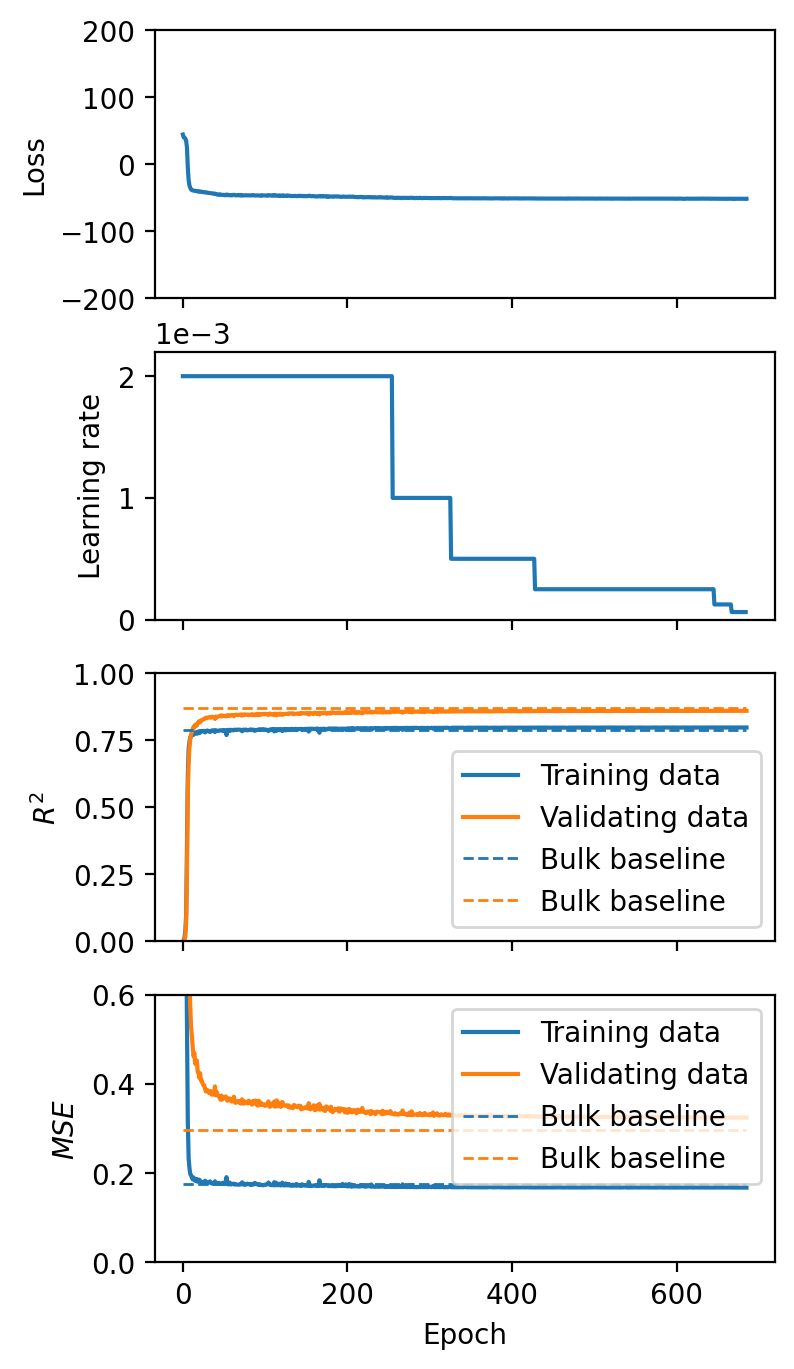

In [77]:
from mlflux.plotting import vis_training
fig, axes = vis_training (log)
axes[0].set_ylim([-200,200])
axes[1].set_ylim([0,0.0022])

nepoch = len(log['LLLoss'])
Yscale = model.Yscale['scale'].numpy().squeeze()

bulk_mse, bulk_r2 = mse_r2(training_data.Bulk.detach().numpy(), training_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C0', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C0', label='Bulk baseline', lw=1)
bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C1', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C1', label='Bulk baseline', lw=1)
axes[2].legend()
axes[3].legend()
axes[2].set_ylim([0,1])
axes[3].set_ylim([0,0.6])

In [11]:
print(log['training_r2'][-1],log['validating_r2'][-1])

[0.8073423] [0.5313098]


In [83]:
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

split = split_ensem[1]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

ikeys = ['U','t_diff','pcos0','plp0','phs0','pcos1','plp1','phs1']
okeys = ['taucx','taucy']
bkeys = ['taubx','tauby']
training_data = WaveFluxDatasetPerm(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
validating_data = WaveFluxDatasetPerm(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
testing_data = WaveFluxDatasetPerm(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
print(bulk_r2)

ikeys = ['U','t_diff','pcos0','plp0','phs0','pcos1','plp1','phs1']
okeys = ['taucx']
bkeys = ['taubx']
training_data = WaveFluxDatasetPerm(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
validating_data = WaveFluxDatasetPerm(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
testing_data = WaveFluxDatasetPerm(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
print(bulk_r2)

Training samples: 8463
Validating samples: 1610
Testing samples: 1610
[ 0.37037188 -0.00241661]
[0.37037218]


In [ ]:
''' Predictor with eight inputs and one outputs. For now only for the momentum fluxes. 
    [Wind, Ua-Uo, W1_cos, W1_lp, W1_hs, W2_cos, W2_lp, W2_hs].
'''
class Flux81(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0,0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,1,1,100,10,1,100,10]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}

''' Basically RealFluxDataset but with random permutation added '''   
class WaveFluxDatasetPerm (RealFluxDataset):
    def __getitem__(self, idx):
        # With 50% chance permutate the two wave systems
        if np.random.rand() > 0.5:
            self.Xperm = torch.cat([self.X[idx][:-6], self.X[idx][-3:], self.X[idx][-6:-3]])
            return self.Xperm, self.Y[idx], self.W[idx]
        else:
            return self.X[idx], self.Y[idx], self.W[idx]